# Imports

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from collections import defaultdict
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier
from arquitecture.SupraCardClassifier import SupraCardClassifier
from utils.AttentionGradCam import AttentionGradCAM


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently using", DEVICE)

Currently using cuda


# Hyperparameters

In [2]:
EPOCH = 300
BATCH_SIZE = 2400
NUN_WORKERS = 6
LR = 0.0004

# Load the pretrained models

In [4]:
csv_file = "cards.csv"
target = "suit"

suit_train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
suit_test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
suit_valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

suit_train_loader = DataLoader(suit_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
suit_valid_loader = DataLoader(suit_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
suit_test_loader  = DataLoader(suit_test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = suit_test_dataset.__getitem__(1)

suit_classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(suit_classifier.n_parameters())
print(len(label))

2373308
5


In [ ]:
csv_file = "cards.csv"
target = "category"

category_train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
category_test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
category_valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

category_train_loader = DataLoader(category_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
category_valid_loader = DataLoader(category_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
category_test_loader  = DataLoader(category_test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = category_test_dataset.__getitem__(1)

category_classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(len(label))

14


In [6]:
print(suit_classifier.n_parameters())
print(category_classifier.n_parameters())

2373308
2373449


In [ ]:

category_checkpoint = torch.load("models/checkpoints/category_classifier_checkpoint.pth")
category_classifier.load_state_dict(category_checkpoint['model_state_dict'])
category_classifier.eval()
category_classifier.to(DEVICE)

suit_checkpoint = torch.load("models/checkpoints/suit_classifier_checkpoint.pth")
suit_classifier.load_state_dict(category_checkpoint['model_state_dict'])
suit_classifier.eval()
suit_classifier.to(DEVICE)

CardClassifier(
  (cnn_block): CNNBlock(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (experts): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): Linear(in_features=64, out_features=54, 

# GradCam

In [7]:
def generateGradCam(result_path: str, split: str, sample_size: int, model: nn.Module, dataset: Dataset):
    target_layer = model.cnn_block.layers[-1]
    attention_layer = model.attention_block.batch_norm
    grad_cam = AttentionGradCAM(model, target_layer, attention_layer)

    # Dict to organize the dictionaries
    indices_por_label = defaultdict(list)
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if hasattr(label, 'argmax'):
            label_int = label.argmax(dim=0).item()
        else:
            label_int = label
        indices_por_label[label_int].append(idx)

    # For each categorie get at least a sample of the sample_size
    for label_val, indices in indices_por_label.items():
        if len(indices) > sample_size:
            sample_indices = random.sample(indices, sample_size)
        else:
            sample_indices = indices

        # Create subplots
        fig, axes = plt.subplots(nrows=len(sample_indices), ncols=2, figsize=(10, 2 * len(sample_indices)))
        fig.suptitle(f"Category {(label_val)}", fontsize=16)

        # Just if the there is only one subplot
        if len(sample_indices) == 1:
            axes = np.expand_dims(axes, axis=0)

        for i, idx in enumerate(sample_indices):
            img, _ = dataset[idx]
            input_tensor = img.unsqueeze(0).to(DEVICE)
            cam, predicted_class = grad_cam.generate_cam(input_tensor)

            # Resize the heatmap into the image size
            cam = cv2.resize(cam, (img.shape[-1], img.shape[-2]))

            # Parse the heatmap into rgb
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

            # Parse the image into rgb instead of grey scale
            img_np = img.squeeze().cpu().numpy()
            img_np = cv2.cvtColor(np.uint8(255 * img_np), cv2.COLOR_GRAY2RGB)

            # Overlab the heatmap
            superimposed_img = cv2.addWeighted(heatmap, 0.4, img_np, 0.6, 0)

            # Show the original image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f"Original (class {(label_val)})")
            axes[i, 0].axis("off")

            # Show the gradcam 
            axes[i, 1].imshow(superimposed_img)
            axes[i, 1].set_title(f"Grad-CAM (prediction {(predicted_class)})")
            axes[i, 1].axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        os.makedirs(f"{result_path}/{split}/BestModel_GradCam/", exist_ok=True)
        plt.savefig(f"{result_path}/{split}/BestModel_GradCam/GradCam_{(label_val)}.png")
        
        plt.close()

/home/lingfeng/Desktop/venvs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


KeyboardInterrupt: 

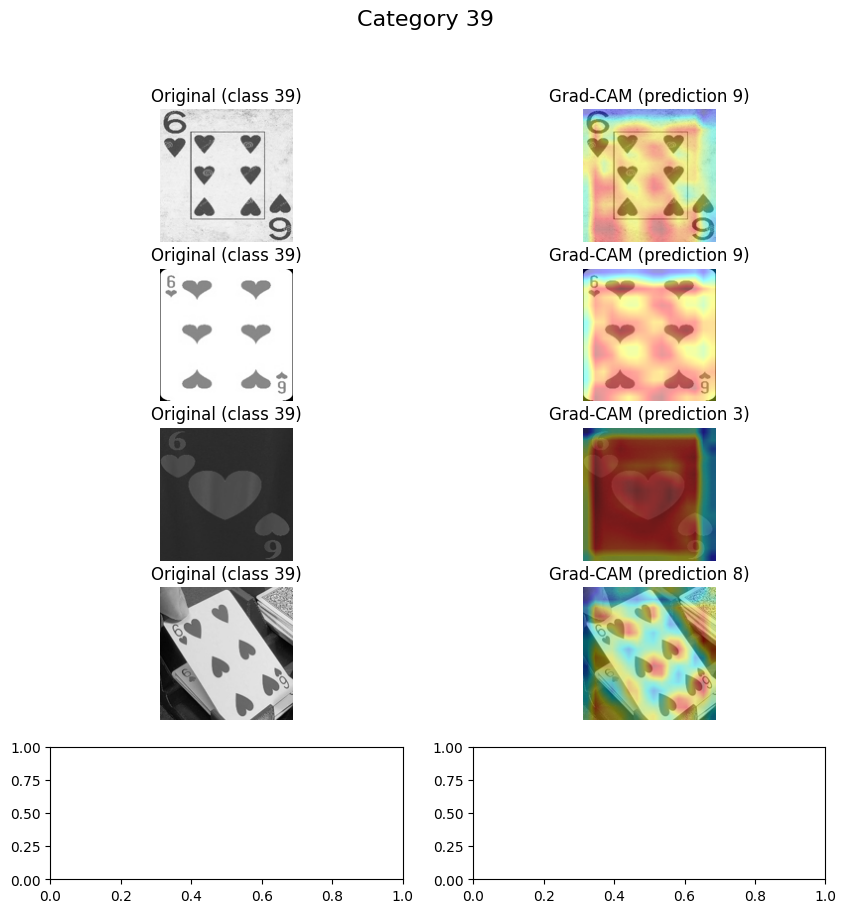

In [8]:
generateGradCam("result", "suit", 5, suit_classifier, suit_test_dataset)
generateGradCam("result", "category", 5, category_classifier, category_test_dataset)